# Crawling Twitter Data based on **Search Keyword** Using `tweet-harvest`
Last updated by Helmi Satria (helmisatria.com) on December 12, 2023

Note: **For educational purposes only**


In [31]:
# # Install Node.js (because tweet-harvest built using Node.js)
# !sudo apt-get update
# !sudo apt-get install -y ca-certificates curl gnupg
# !sudo mkdir -p /etc/apt/keyrings
# !curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg

# !NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list

# !sudo apt-get update
# !sudo apt-get install nodejs -y

# !node -v

In [32]:
# # Crawl Data

# filename = 'pemilu.csv'
# search_keyword = '#DebatCapres until:2024-01-08 since:2024-01-06'
# limit = 3000

# !npx --yes tweet-harvest@2.2.8 -o "{filename}" -s "{search_keyword}" -l {limit} --token ""

In [33]:
import pandas as pd
import nltk, os, re, string
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nlp_id.lemmatizer import Lemmatizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to C:\Users\asus.LAPTOP-
[nltk_data]     P9TBK6TS.000\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\asus.LAPTOP-
[nltk_data]     P9TBK6TS.000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\asus.LAPTOP-
[nltk_data]     P9TBK6TS.000\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to C:\Users
[nltk_data]     \asus.LAPTOP-P9TBK6TS.000\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [34]:
df = pd.read_csv('pemilu (3).csv', delimiter=";")

display(df)

,created_at,id_str,full_text,quote_count,reply_count,retweet_count,favorite_count,lang,user_id_str,conversation_id_str,username,tweet_url
0,Sun Jan 07 23:55:32 +0000 2024,1744145777877037180,jiahahaha prabowo dicebokin bot #DebatCapres,0,0,0,1,in,1431142289884135428,1744145777877037180,hochidubu,https://twitter.com/hochidubu/status/174414577...
1,Sun Jan 07 23:54:50 +0000 2024,1744145600130711777,Biar masyarakat yg menilai ya pak. #02KubuArog...,0,0,0,2,in,1723961822829809664,1744145600130711777,archie99634,https://twitter.com/archie99634/status/1744145...
2,Sun Jan 07 23:54:32 +0000 2024,1744145523194638522,@erlanishere @Gerindra Dan diungkap di #DebatC...,0,0,0,0,in,604333557,1744004360651292983,rektrektrekt123,https://twitter.com/rektrektrekt123/status/174...
3,Sun Jan 07 23:53:34 +0000 2024,1744145279849542072,Jubir TKD Jatim: Prabowo akan Memperkuat Siste...,0,0,0,0,in,21287066,1744145279849542072,beritajatimcom,https://twitter.com/beritajatimcom/status/1744...
4,Sun Jan 07 23:52:51 +0000 2024,1744145100048077090,@RadioElshinta ANIES ROCKS DEBAT CAPRES !! #D...,0,0,1,3,en,129750289,1743960193225150558,ZAEffendy,https://twitter.com/ZAEffendy/status/174414510...
...,...,...,...,...,...,...,...,...,...,...,...,...
560,Sun Jan 07 21:57:32 +0000 2024,1744116079222501735,Keunggulan teknologi bukanlah pilihan tapi keh...,0,0,0,0,in,1725075851006664705,1744116079222501735,zarahanara,https://twitter.com/zarahanara/status/17441160...
561,Sun Jan 07 21:57:31 +0000 2024,1744116078589169724,Ganjar-Mahfud yakin investasi pada alutsista t...,0,0,0,0,in,1726072719366934528,1744116078589169724,rizkiirwas,https://twitter.com/rizkiirwas/status/17441160...
562,Sun Jan 07 21:57:31 +0000 2024,1744116077779673144,Pembelian alutsista sesuai kebutuhan masa kini...,0,0,0,0,in,1725062133904490496,1744116077779673144,raraaisyahh,https://twitter.com/raraaisyahh/status/1744116...
563,Sun Jan 07 21:57:27 +0000 2024,1744116060465586624,Alutsista yg terkini performa yg luar biasa @i...,0,0,0,0,in,1717020263181946880,1744116060465586624,rianamstk,https://twitter.com/rianamstk/status/174411606...


In [35]:
data = df[['created_at', 'username', 'full_text']]

data.head(10)

,created_at,username,full_text
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot #DebatCapres
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,Biar masyarakat yg menilai ya pak. #02KubuArog...
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,@erlanishere @Gerindra Dan diungkap di #DebatC...
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,Jubir TKD Jatim: Prabowo akan Memperkuat Siste...
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,@RadioElshinta ANIES ROCKS DEBAT CAPRES !! #D...
5,Sun Jan 07 23:52:16 +0000 2024,ShireenEsa90311,"Israel, claims humanity and is saddened by the..."
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,Tetap semangat Jepang Barat Korea Fansite Indo...
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,Yang mendesak El Gemoy itu baru satu orang saj...
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,Itu pendukung pak anies apa ga ada yang hilang...
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,Ada yang pernah ngerasain seperti ini? 😭 - A ...


In [36]:
from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang
    except:
        return 'unknown'

# Menambahkan kolom baru untuk menyimpan hasil deteksi bahasa
data['Language'] = data['full_text'].apply(detect_language)

# Memfilter tweet yang bahasa Indonesiannya terdeteksi
data = data[data['Language'] == 'id']

C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_29264\2670641184.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Language'] = data['full_text'].apply(detect_language)


In [37]:
data.head(10)

,created_at,username,full_text,Language
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot #DebatCapres,id
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,Biar masyarakat yg menilai ya pak. #02KubuArog...,id
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,@erlanishere @Gerindra Dan diungkap di #DebatC...,id
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,Jubir TKD Jatim: Prabowo akan Memperkuat Siste...,id
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,@RadioElshinta ANIES ROCKS DEBAT CAPRES !! #D...,id
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,Tetap semangat Jepang Barat Korea Fansite Indo...,id
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,Yang mendesak El Gemoy itu baru satu orang saj...,id
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,Itu pendukung pak anies apa ga ada yang hilang...,id
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,Ada yang pernah ngerasain seperti ini? 😭 - A ...,id
11,Sun Jan 07 23:50:00 +0000 2024,TPNGanjarMahfud,"Promosi RI di Dunia, Ganjar Mau Pakai Viralism...",id


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406 entries, 0 to 564
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  406 non-null    object
 1   username    406 non-null    object
 2   full_text   406 non-null    object
 3   Language    406 non-null    object
dtypes: object(4)
memory usage: 15.9+ KB


In [39]:
data.shape

(406, 4)

In [40]:
df_slang = pd.read_csv('kamus-alay\colloquial-indonesian-lexicon.csv')  # Ganti 'daftar_slang.csv' dengan nama file CSV Anda

# Fungsi untuk mengubah kata slang menjadi kata formal
def replace_slang(text):
    words = text.split()
    for i in range(len(words)):
        slang_word = df_slang[df_slang['slang'] == words[i]]
        if not slang_word.empty:
            words[i] = slang_word['formal'].values[0]
    return ' '.join(words)

In [41]:
data['full_text'] = data['full_text'].apply(replace_slang)

In [42]:
data.head(10)

,created_at,username,full_text,Language
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot #DebatCapres,id
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,Biar masyarakat yang menilai ya pak. #02KubuAr...,id
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,@erlanishere @Gerindra Dan diungkap di #DebatC...,id
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,Jubir TKD Jatim: Prabowo akan Memperkuat Siste...,id
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,@RadioElshinta ANIES ROCKS DEBAT CAPRES !! #De...,id
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,Tetap semangat Jepang Barat Korea Fansite Indo...,id
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,Yang mendesak El Gemoy itu baru satu orang saj...,id
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,Itu pendukung pak anies apa enggak ada yang hi...,id
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,Ada yang pernah merasai seperti ini? 😭 - A Thr...,id
11,Sun Jan 07 23:50:00 +0000 2024,TPNGanjarMahfud,"Promosi RI di Dunia, Ganjar Mau Pakai Viralism...",id


In [43]:
import re

def remove_tweet_special(text):
    # Menghapus tab, baris baru, dan back slice
    text = text.replace('\\t', ' ').replace('\\n', ' ').replace('\\u', ' ').replace('\\', '')

    # Menghapus karakter non-ASCII (emotikon, huruf Cina, dll.)
    text = text.encode('ascii', 'replace').decode('ascii')

    # Menghapus mention, link, dan hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())

    # Menghapus URL yang tidak lengkap
    text = text.replace("http://", " ").replace("https://", " ")

    return text

def clean_text(data):
    # Menghapus karakter yang tidak diinginkan (_) dan karakter selain huruf
    data['full_text'] = data['full_text'].str.replace(r"[^a-zA-Z ]+", " ").str.strip()

    # Mengganti multiple whitespace dengan single whitespace
    data['full_text'] = data['full_text'].replace(" +", " ", regex=True)

    return data

# Menggunakan fungsi remove_tweet_special untuk membersihkan teks
data['full_text'] = data['full_text'].apply(remove_tweet_special)

# Menggunakan fungsi clean_text untuk membersihkan karakter yang tidak diinginkan
data = clean_text(data)


In [44]:
def clean_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

lemmatizer = Lemmatizer()

def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

def remove_numbers(text):
    return re.sub('[0-9]+', '', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words('indonesian'))
    return ' '.join([word for word in nltk.word_tokenize(text) if word.lower() not in stop_words])

data['full_text'] = data['full_text'].apply(lambda x: x.lower())

data['full_text'] = data['full_text'].apply(clean_punctuation)

data['full_text'] = data['full_text'].apply(lemmatize_text)

data['full_text'] = data['full_text'].apply(remove_numbers)

data['full_text'] = data['full_text'].apply(remove_stopwords)

In [45]:
data.head(10)

,created_at,username,full_text,Language
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot,id
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,biar masyarakat nilai ya,id
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,tonton jagat,id
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,jubir tkd jatim prabowo kuat sistem militer in...,id
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,anies rocks debat capres,id
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,semangat jepang barat korea fansite indonesia ...,id
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,desak el gemoy orang amp beliau malas salam ma...,id
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,dukung anies hilang respect gara gara nyenggol...,id
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,rasai a thread meme paslon blunder wowo,id
11,Sun Jan 07 23:50:00 +0000 2024,TPNGanjarMahfud,promosi ri dunia ganjar pakai viralisme teknol...,id


In [46]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Inisialisasi Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk melakukan stemming pada setiap teks dalam kolom 'full_text'
def stem_text(text):
    return stemmer.stem(text)

# Melakukan stemming pada kolom 'full_text'
data['full_text_stemmed'] = data['full_text'].apply(stem_text)

# Menampilkan hasil stemming
data.head(10)


,created_at,username,full_text,Language,full_text_stemmed
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot,id,jiahahaha prabowo dicebokin bot
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,biar masyarakat nilai ya,id,biar masyarakat nilai ya
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,tonton jagat,id,tonton jagat
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,jubir tkd jatim prabowo kuat sistem militer in...,id,jubir tkd jatim prabowo kuat sistem militer in...
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,anies rocks debat capres,id,anies rocks debat capres
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,semangat jepang barat korea fansite indonesia ...,id,semangat jepang barat korea fansite indonesia ...
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,desak el gemoy orang amp beliau malas salam ma...,id,desak el gemoy orang amp beliau malas salam ma...
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,dukung anies hilang respect gara gara nyenggol...,id,dukung anies hilang respect gara gara nyenggol...
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,rasai a thread meme paslon blunder wowo,id,rasai a thread meme paslon blunder wowo
11,Sun Jan 07 23:50:00 +0000 2024,TPNGanjarMahfud,promosi ri dunia ganjar pakai viralisme teknol...,id,promosi ri dunia ganjar pakai viralisme teknol...


In [47]:
file_negative = 'InSet/negative.tsv'
file_positive = 'Inset/positive.tsv'

data_negative = pd.read_csv(file_negative, sep='\t')
data_positive = pd.read_csv(file_positive, sep='\t')

# Tambahkan kolom label sentimen
data_negative['sentiment'] = 'negative'
data_positive['sentiment'] = 'positive'

# Gabungkan dataset negative dan positive menjadi satu dataset
data_combined = pd.concat([data_negative, data_positive], ignore_index=True)

# Tampilkan beberapa contoh data
data_combined.head(10)


,word,weight,sentiment
0,putus tali gantung,-2,negative
1,gelebah,-2,negative
2,gobar hati,-2,negative
3,tersentuh (perasaan),-1,negative
4,isak,-5,negative
5,larat hati,-3,negative
6,nelangsa,-3,negative
7,remuk redam,-5,negative
8,tidak segan,-2,negative
9,gemar,-1,negative


In [48]:
# Mengonversi ke dalam kamus dengan kata sebagai kunci dan bobot sebagai nilai
word_weight_dict = dict(zip(data_combined['word'], data_combined['weight']))

# Fungsi untuk menentukan sentimen kata dalam teks
def determine_sentiment(word):
    if word in word_weight_dict:
        if word_weight_dict[word] < 0:
            return 'negatif'
        elif word_weight_dict[word] > 0:
            return 'positif'
    return 'netral'

# Contoh kalimat
kalimat = "Ini adalah contoh kalimat untuk pengujian sentimen kata."

# Tokenisasi kalimat
tokens = kalimat.split()

# Menentukan sentimen untuk setiap kata dalam kalimat
sentimen_kata = {kata: determine_sentiment(kata) for kata in tokens}

print(sentimen_kata)

{'Ini': 'netral', 'adalah': 'netral', 'contoh': 'netral', 'kalimat': 'negatif', 'untuk': 'netral', 'pengujian': 'netral', 'sentimen': 'negatif', 'kata.': 'netral'}


In [49]:
data.head(10)

,created_at,username,full_text,Language,full_text_stemmed
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot,id,jiahahaha prabowo dicebokin bot
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,biar masyarakat nilai ya,id,biar masyarakat nilai ya
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,tonton jagat,id,tonton jagat
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,jubir tkd jatim prabowo kuat sistem militer in...,id,jubir tkd jatim prabowo kuat sistem militer in...
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,anies rocks debat capres,id,anies rocks debat capres
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,semangat jepang barat korea fansite indonesia ...,id,semangat jepang barat korea fansite indonesia ...
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,desak el gemoy orang amp beliau malas salam ma...,id,desak el gemoy orang amp beliau malas salam ma...
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,dukung anies hilang respect gara gara nyenggol...,id,dukung anies hilang respect gara gara nyenggol...
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,rasai a thread meme paslon blunder wowo,id,rasai a thread meme paslon blunder wowo
11,Sun Jan 07 23:50:00 +0000 2024,TPNGanjarMahfud,promosi ri dunia ganjar pakai viralisme teknol...,id,promosi ri dunia ganjar pakai viralisme teknol...


In [50]:
def test_sentiment(data):
    # Tokenisasi teks dan menentukan sentimen untuk setiap kata dalam kolom 'full_text'
    data['sentiment'] = data['full_text'].apply(lambda x: [determine_sentiment(word) for word in x.split()])
    return data

def calculate_text_weight(text):
    total_weight = 0
    words = text.split()
    for word in words:
        if word in word_weight_dict:
            total_weight += word_weight_dict[word]
    return total_weight

# Menghitung nilai bobot untuk setiap teks dalam kolom 'full_text'
data['text_weight'] = data['full_text'].apply(calculate_text_weight)

data = test_sentiment(data)

# Menampilkan hasil sentimen kata dalam kolom 'full_text'
data.head(10)

,created_at,username,full_text,Language,full_text_stemmed,text_weight,sentiment
0,Sun Jan 07 23:55:32 +0000 2024,hochidubu,jiahahaha prabowo dicebokin bot,id,jiahahaha prabowo dicebokin bot,-2,"[netral, netral, netral, negatif]"
1,Sun Jan 07 23:54:50 +0000 2024,archie99634,biar masyarakat nilai ya,id,biar masyarakat nilai ya,10,"[positif, netral, positif, positif]"
2,Sun Jan 07 23:54:32 +0000 2024,rektrektrekt123,tonton jagat,id,tonton jagat,-4,"[negatif, netral]"
3,Sun Jan 07 23:53:34 +0000 2024,beritajatimcom,jubir tkd jatim prabowo kuat sistem militer in...,id,jubir tkd jatim prabowo kuat sistem militer in...,-3,"[netral, netral, netral, netral, positif, nega..."
4,Sun Jan 07 23:52:51 +0000 2024,ZAEffendy,anies rocks debat capres,id,anies rocks debat capres,3,"[netral, netral, positif, netral]"
6,Sun Jan 07 23:52:05 +0000 2024,AminudinRashya,semangat jepang barat korea fansite indonesia ...,id,semangat jepang barat korea fansite indonesia ...,-3,"[positif, netral, netral, netral, netral, netr..."
7,Sun Jan 07 23:51:07 +0000 2024,ceasarru,desak el gemoy orang amp beliau malas salam ma...,id,desak el gemoy orang amp beliau malas salam ma...,-10,"[positif, negatif, netral, netral, netral, net..."
8,Sun Jan 07 23:50:39 +0000 2024,radenimanuel1,dukung anies hilang respect gara gara nyenggol...,id,dukung anies hilang respect gara gara nyenggol...,-2,"[positif, netral, positif, netral, negatif, ne..."
9,Sun Jan 07 23:50:06 +0000 2024,maul_af,rasai a thread meme paslon blunder wowo,id,rasai a thread meme paslon blunder wowo,1,"[positif, netral, netral, netral, netral, netr..."
11,Sun Jan 07 23:50:00 +0000 2024,TPNGanjarMahfud,promosi ri dunia ganjar pakai viralisme teknol...,id,promosi ri dunia ganjar pakai viralisme teknol...,6,"[netral, netral, positif, positif, netral, net..."


In [51]:
data = data[['created_at', 'full_text', 'text_weight']]

data.head()

,created_at,full_text,text_weight
0,Sun Jan 07 23:55:32 +0000 2024,jiahahaha prabowo dicebokin bot,-2
1,Sun Jan 07 23:54:50 +0000 2024,biar masyarakat nilai ya,10
2,Sun Jan 07 23:54:32 +0000 2024,tonton jagat,-4
3,Sun Jan 07 23:53:34 +0000 2024,jubir tkd jatim prabowo kuat sistem militer in...,-3
4,Sun Jan 07 23:52:51 +0000 2024,anies rocks debat capres,3


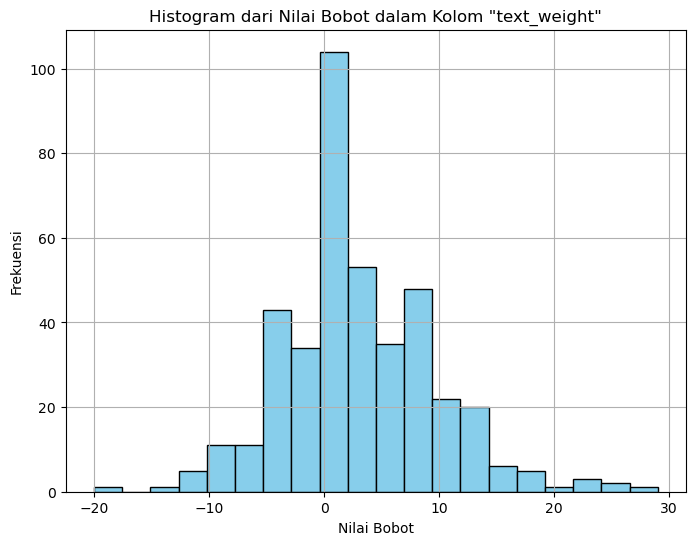

In [57]:
import matplotlib.pyplot as plt

# Melakukan import data dan perhitungan bobot seperti sebelumnya

# Membuat histogram dari nilai bobot dalam kolom 'text_weight'
plt.figure(figsize=(8, 6))
plt.hist(data['text_weight'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram dari Nilai Bobot dalam Kolom "text_weight"')
plt.xlabel('Nilai Bobot')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

In [53]:
# tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')

# #Menggunakan fit_on_texts untuk mengonversi teks menjadi token
# tokenizer.fit_on_texts(data['full_text'])

# # Konversi teks menjadi sequence
# data_sequences = tokenizer.texts_to_sequences(data['full_text'])

# padded_train = pad_sequences(data_sequences)

# # Menampilkan hasil sequence
# print(padded_train)

# # tokenizer.fit_on_texts(Train_X)
# # tokenizer.fit_on_texts(Test_X)

# # sekuens_train = tokenizer.texts_to_sequences(Train_X)
# # sekuens_test = tokenizer.texts_to_sequences(Test_X)

# # padded_train = pad_sequences(sekuens_train)
# # padded_test = pad_sequences(sekuens_test)

[[   0    0    0 ...    8  534  535]
 [   0    0    0 ...   90  117   15]
 [   0    0    0 ...    0   35  536]
 ...
 [   0    0    0 ...  212    2  505]
 [   0    0    0 ...    0    7 1413]
 [   0    0    0 ...   12  133  519]]


In [59]:
tokenizer = Tokenizer()

# Melakukan fit pada teks dalam kolom 'full_text'
tokenizer.fit_on_texts(data['full_text'])

# Melakukan konversi teks menjadi sequence
data_sequences = tokenizer.texts_to_sequences(data['full_text'])

In [60]:
Train_X, Test_X, Train_Y, Test_Y = train_test_split(data['full_text'], data['text_weight'], test_size=0.2, shuffle=True)

In [61]:
print(f'Jumlah data dalam train set: {len(Train_X)}')
print(f'Jumlah data dalam validation set: {len(Test_X)}')
print(f'Jumlah data dalam train set: {len(Train_Y)}')
print(f'Jumlah data dalam validation set: {len(Test_Y)}')

Jumlah data dalam train set: 324
Jumlah data dalam validation set: 82
Jumlah data dalam train set: 324
Jumlah data dalam validation set: 82


In [72]:
from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()

Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.transform(Test_Y)


ValueError: y contains previously unseen labels: [-13, -12, -10, -8, -7, -5, -4, -3, -2, -1]

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(data['full_text'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)


In [69]:
from sklearn import naive_bayes

Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, Train_Y)


MultinomialNB()

In [70]:
predictions_NB = Naive.predict(Test_X_Tfidf)

from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, classification_report

print(confusion_matrix(predictions_NB,Test_Y))
print ("Classification: ",classification_report(Test_Y,predictions_NB))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 

c:\Users\asus.LAPTOP-P9TBK6TS.000\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus.LAPTOP-P9TBK6TS.000\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus.LAPTOP-P9TBK6TS.000\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Use

In [71]:
print("Naive Bayes Accuracy Score -> ", accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  1.2195121951219512
